# Import libraries and read data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
# set default plot settings
size = (8, 5)
dpi = (300)

In [3]:
# read extraction
paper_data = pd.read_excel('SLR_extraction.xlsx', 'Extraction').iloc[1:, :]

# skip example row
paper_data = paper_data.iloc[1:, :]

# remove final row showing percentage filled
paper_data = paper_data.iloc[:len(paper_data)-2, :]

# change '-' to 'not mentioned'
paper_data = paper_data.replace('-', 'Not mentioned')

# create dataset with one row per foodrec
model_data = paper_data.copy()

# extract each system into separate rows
for col in ['Algorithm', 'Method']:
    # check if extraction contains multiple values
    if any(model_data[col].str.contains(', ')):
        # list multiple entries together
        model_data.loc[:, col] = model_data[col].str.split(', ', expand=False)
        # expand list to multiple rows
        model_data = model_data.explode(col)

# General section

## Paper types

In [121]:
# distribution of paper-types
type_count = pd.DataFrame(paper_data['Type'].value_counts())
type_count['freq'] = type_count/type_count.sum()
print(type_count)

                       Type      freq
Conference proceeding    38  0.567164
Article                  29  0.432836


## Quality of papers

In [5]:
# read quality assessment sheet
quality_df = pd.read_excel('SLR_extraction.xlsx', 'Quality Assessment', header=2)
quality_df = pd.concat([quality_df['Assessment'], quality_df['Total score']], axis=1)

/Users/jnb/thesis/frs/code/env/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/jnb/thesis/frs/code/env/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


In [123]:
threshold = quality_df['Total score'].max()/2

In [124]:
# count the different scores
scores = quality_df['Total score'].value_counts().sort_index()

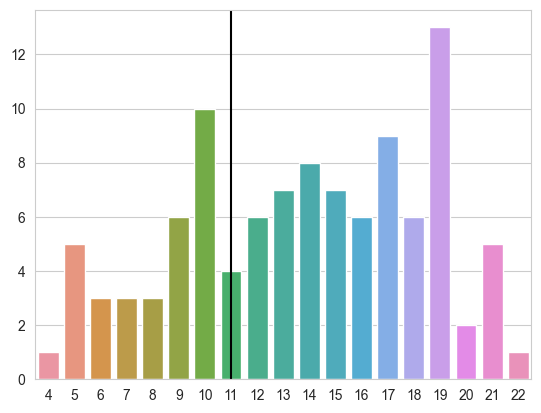

In [125]:
'''Distribution of scores for the retrieved papers.
fig:score_dist | score_dist.png '''
_ = sns.barplot(x=scores.index, y=scores.values)
_ = plt.axvline(threshold - min(scores.index), color='black')
plt.savefig('plots/score_dist.png', dpi=dpi)

In [126]:
# statistics of quality score distribution
quality_df['Total score'].describe()

count    105.000000
mean      13.723810
std        4.635762
min        4.000000
25%       10.000000
50%       14.000000
75%       18.000000
max       22.000000
Name: Total score, dtype: float64

## Publications per year

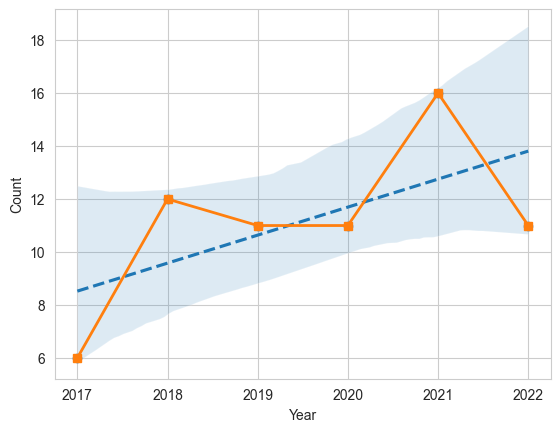

In [127]:
'''
Number of publications each year.
fig:pub_dist | pub_dist.png
'''

# count the occurence of years
pub_count = pd.DataFrame(paper_data['Year'].value_counts().sort_index())
pub_count = pub_count.reset_index().astype(int)
pub_count.columns = ['Year', 'Count']

# plot
sns.regplot(x='Year', y='Count', data=pub_count, line_kws={'ls': '--'})
_ = plt.plot(pub_count['Year'], pub_count['Count'], 's-', linewidth = 2, markersize=6)
plt.savefig('plots/pub_dist.png', dpi=dpi)

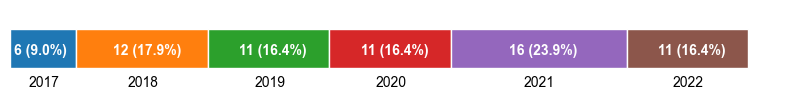

In [128]:
'''
Distribution of publications per year in a stacked bar plot.
fig:pub_dist | stacked_pub_dist.png
'''

cross_tab=pd.crosstab(index='Count', columns=paper_data['Year'].values)

cross_tab_prop=pd.crosstab(index='Count', columns=paper_data['Year'].values, normalize='index')

cross_tab_prop.plot(
    kind='barh',
    stacked=True,
    figsize=(10,1),
    style='default',
    ylabel='',
    xlabel='',
    legend=None
)

for n, x in enumerate([*cross_tab.index.values]):
    for (proportion, count, y_loc, year) in zip(cross_tab_prop.loc[x],
                                          cross_tab.loc[x],
                                          cross_tab_prop.loc[x].cumsum(),
                                          cross_tab.columns):
        # counts        
        plt.text(x=(y_loc - proportion - .04) + (proportion / 2),
                 y=n - 0.09,
                 s=f'{count} ({np.round(proportion * 100, 1)}%)', 
                 color="white",
                 fontsize=10,
                 fontweight="bold")
        plt.text(x=(y_loc - proportion - .02) + (proportion / 2),
                 y=-.5,
                    s=f'{year}', 
                    color="black",
                    fontsize=10,
                    fontweight="light")

_ = plt.axis('off')
plt.savefig('plots/stacked_pub_dist.png', dpi=dpi)

## Publications per venue

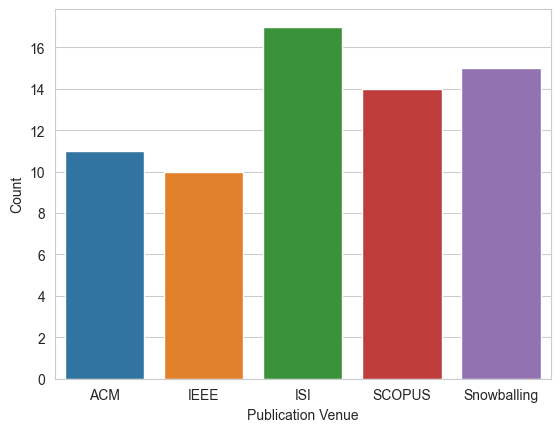

In [129]:
'''
Number of venue-publications
fig:venue_dist | venue_dist.png
'''

venue_count = paper_data['Publication Venue'].value_counts().sort_index()
_ = sns.barplot(x=venue_count.index, y=venue_count.values)
_ = plt.xlabel('Publication Venue')
_ = plt.ylabel('Count')
plt.savefig('plots/venue_dist.png', dpi=dpi)

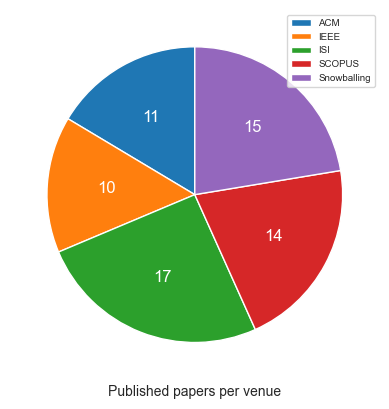

In [130]:
'''
Pie venue publications
fig:pie_venue_dist | pie_venue_dist.png
'''
venue_count = paper_data['Publication Venue'].value_counts().sort_index()
_ = plt.pie(x=venue_count.values, autopct=lambda x: '{:.0f}'.format(x*venue_count.values.sum()/100), textprops={'color':"w", 'size': 12}, startangle=90)
_ = plt.legend(venue_count.index, prop={'size': 7})
_ = plt.xlabel('Published papers per venue')
plt.savefig('plots/pie_venue_dist.png', dpi=dpi)

In [131]:
# percentages for the different venues
print(paper_data['Publication Venue'].value_counts().sort_values())
print(paper_data['Publication Venue'].value_counts(normalize=True).sort_values()*100)

IEEE           10
ACM            11
SCOPUS         14
Snowballing    15
ISI            17
Name: Publication Venue, dtype: int64
IEEE           14.925373
ACM            16.417910
SCOPUS         20.895522
Snowballing    22.388060
ISI            25.373134
Name: Publication Venue, dtype: float64


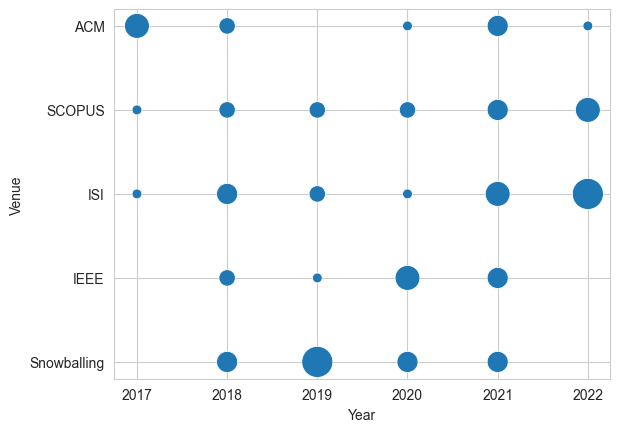

In [132]:
'''
Number of venue-publications per year
fig:venue_year_dist | venue_year_dist.png
'''
# get number of publication per venue per year
venue_count = paper_data[['Publication Venue', 'Year']].value_counts().rename_axis(['Venue', 'Year']).reset_index(name='Count').sort_values(by='Year')

# increase size difference
venue_count['Count'] = venue_count['Count']

# plot
_ = sns.scatterplot(data=venue_count, x='Year', y='Venue', size='Count', sizes=(50,500), legend=False)
#plt.savefig('plots/venue_year_dist.png')

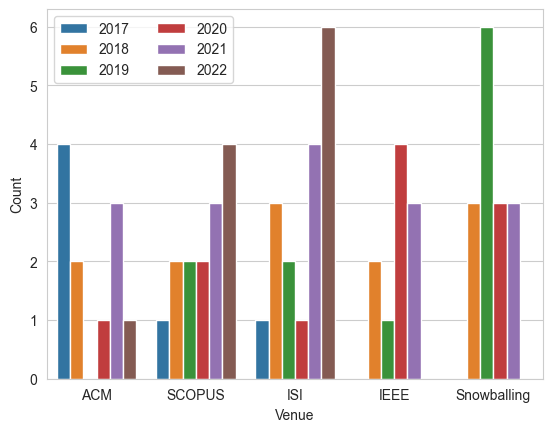

In [133]:
'''
Number of venue-publications per year
fig:venues_year | venues_year.png
'''
# get number of publication per venue per year
venue_count = paper_data[['Publication Venue', 'Year']].value_counts().rename_axis(['Venue', 'Year']).reset_index(name='Count').sort_values(by='Year')

# plot
_ = sns.barplot(data=venue_count, x='Venue', y='Count', hue='Year')
_ = plt.legend(prop={'size': 10}, loc='upper left', ncol=2)
plt.savefig('plots/venues_year.png', dpi=dpi)

## Publications per author

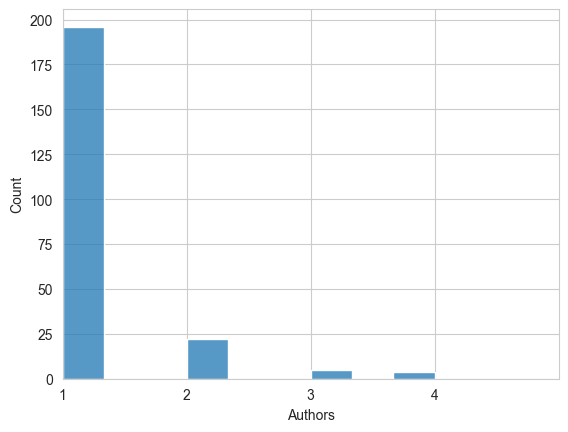

In [134]:
'''
Distribution of publications per author.
fig:authordist | authordist.png
'''
authors = paper_data['Authors'].str.split(', ', expand=False).explode()
author_count = authors.value_counts().sort_values(ascending=False)
_ = sns.histplot(x=author_count)
_ = plt.xlabel('Authors')
_ = plt.ylabel('Count')
_ = plt.xticks(ticks=[1,2,3,4])
_ = plt.xlim(1,5)
plt.savefig('plots/allauthordist.png', dpi=dpi)

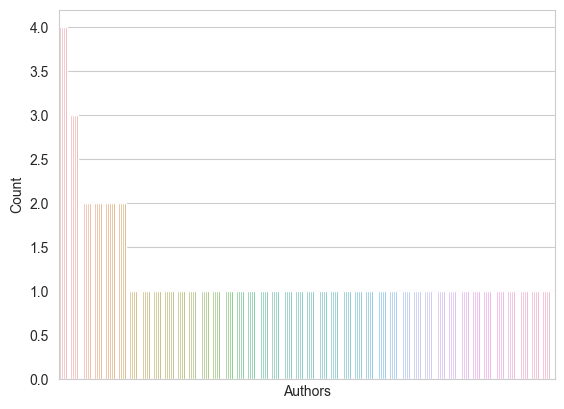

In [135]:
'''
Distribution of publications per author.
fig:authordist | authordist.png
'''
authors = paper_data['Authors'].str.split(', ', expand=False).explode()
author_count = authors.value_counts().sort_values(ascending=False)
_ = sns.barplot(x=author_count.index, y=author_count.values)
_ = plt.xlabel('Authors')
_ = plt.ylabel('Count')
_ = plt.xticks(ticks=[])
plt.savefig('plots/authordist.png', dpi=dpi)

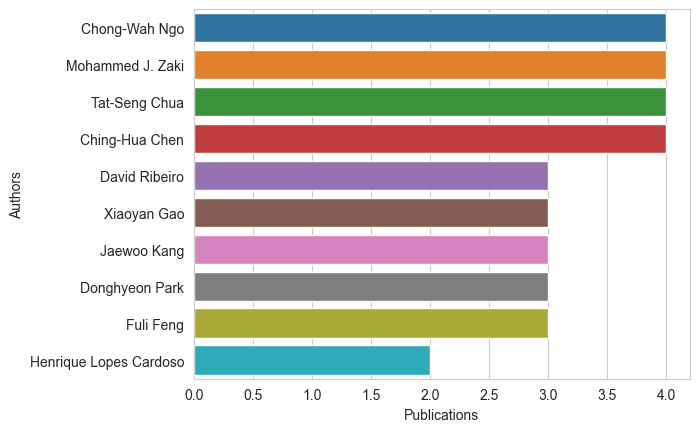

In [136]:
'''
Number of publications for the top ten published authors.
fig:top10authors | top10authors.png
'''
_ = sns.barplot(y=author_count[:10].index, x=author_count[:10].values, orient='h')
_ = plt.xlabel('Publications')
_ = plt.ylabel('Authors')
plt.savefig('plots/top10authors.png', bbox_inches='tight', dpi=dpi)

In [137]:
author_count.head(20)

Chong-Wah Ngo             4
Mohammed J. Zaki          4
Tat-Seng Chua             4
Ching-Hua Chen            4
David Ribeiro             3
Xiaoyan Gao               3
Jaewoo Kang               3
Donghyeon Park            3
Fuli Feng                 3
Henrique Lopes Cardoso    2
Lei Pang                  2
Ling-Yu Duan              2
Jing-Jing Chen            2
Yu Chen                   2
Ronald Metoyer            2
Chuxu Zhang               2
Yijun Tian                2
Heyan Huang               2
Michael Spranger          2
Nitesh V. Chawla          2
Name: Authors, dtype: int64

In [138]:
# get statistics
author_count.describe()

count    227.000000
mean       1.193833
std        0.554433
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        4.000000
Name: Authors, dtype: float64

In [139]:
print(
    'Number of unique authors:', 
    len(authors.unique()))
print(
    'Number of authors with more than one paper:',
    len(author_count[author_count > 1])
)

Number of unique authors: 227
Number of authors with more than one paper: 31


In [140]:
len(author_count[author_count == 2])

22

# RQ1 What are the techniques used in Food Recommendation Systems?

In [141]:
# make dataset with related extraction-points
rq1 = model_data.loc[:, ['Method', 'Personalisation', 'Algorithm', 'Year']]

In [142]:
rq1.head()

,Method,Personalisation,Algorithm,Year
1,Hybrid methods,Personalised,Statistics,2017
2,Content-based filtering,Not personalised,Statistics,2017
3,Content-based filtering,Not personalised,Machine Learning,2018
4,Collaborative filtering,Personalised,Statistics,2021
5,Graph-based methods,Personalised,Query,2018


In [143]:
print(
    'Number of recommendation systems:',
    len(rq1)
)

Number of recommendation systems: 71


In [144]:
# counts
print('-'*50)
print(rq1['Method'].value_counts(normalize=True))

print('-'*50)
print(rq1['Personalisation'].value_counts(normalize=True))

print('-'*50)
print(rq1['Algorithm'].value_counts(normalize=True))

--------------------------------------------------
Content-based filtering    0.521127
Graph-based methods        0.211268
Collaborative filtering    0.169014
Hybrid methods             0.098592
Name: Method, dtype: float64
--------------------------------------------------
Not personalised    0.507042
Personalised        0.492958
Name: Personalisation, dtype: float64
--------------------------------------------------
Machine Learning    0.690141
Statistics          0.211268
Query               0.070423
Not mentioned       0.028169
Name: Algorithm, dtype: float64


## Recommendation Method

In [145]:
print('Recommendation methods in 2022')
rq1.loc[rq1['Year'] == '2022', ['Method', 'Year']].value_counts()

Recommendation methods in 2022


Method                   Year
Graph-based methods      2022    7
Collaborative filtering  2022    2
Content-based filtering  2022    2
dtype: int64

In [146]:
# get all methods
methods = model_data['Method'].unique()

# loop over algorithms
for method in methods:
    print('-'*50)
    print('Method:', method)
    meth = model_data[model_data['Method'] == method]
    #
    print(meth['Algorithm'].value_counts())
    print(meth['Personalisation'].value_counts())

--------------------------------------------------
Method: Hybrid methods
Machine Learning    5
Statistics          2
Name: Algorithm, dtype: int64
Personalised        6
Not personalised    1
Name: Personalisation, dtype: int64
--------------------------------------------------
Method: Content-based filtering
Machine Learning    27
Statistics           8
Query                2
Name: Algorithm, dtype: int64
Not personalised    28
Personalised         9
Name: Personalisation, dtype: int64
--------------------------------------------------
Method: Collaborative filtering
Machine Learning    8
Statistics          4
Name: Algorithm, dtype: int64
Personalised        9
Not personalised    3
Name: Personalisation, dtype: int64
--------------------------------------------------
Method: Graph-based methods
Machine Learning    9
Query               3
Not mentioned       2
Statistics          1
Name: Algorithm, dtype: int64
Personalised        11
Not personalised     4
Name: Personalisation, dtype

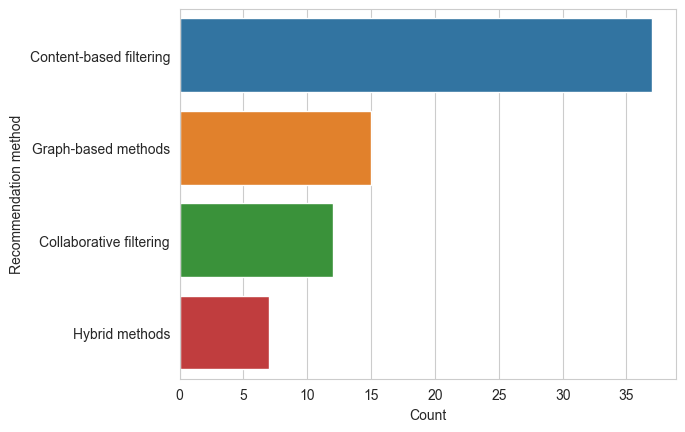

In [147]:
'''
Distribution of methods.
fig:methods | methods.png
 '''
# plot the use of the different algorithms
# fig:relative_algorithm_use

method_count = model_data['Method'].value_counts()

_ = sns.barplot(y=method_count.index, x=method_count.values)
_ = plt.ylabel('Recommendation method')
_ = plt.xlabel('Count')
plt.savefig('plots/methods.png', dpi=dpi, bbox_inches='tight')

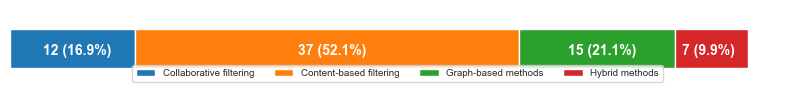

In [148]:
'''
Distribution of methods in a stacked bar plot.
fig:methods_stacked | methods_stacked.png
'''

cross_tab=pd.crosstab(index='Count', columns=model_data['Method'].values)

cross_tab_prop=pd.crosstab(index='Count', columns=model_data['Method'].values, normalize='index')

cross_tab_prop.plot(
    kind='barh',
    stacked=True,
    figsize=(10,1),
    style='default',
    ylabel='',
    xlabel=''
)

for n, x in enumerate([*cross_tab.index.values]):
    for (proportion, count, y_loc) in zip(cross_tab_prop.loc[x],
                                          cross_tab.loc[x],
                                          cross_tab_prop.loc[x].cumsum()):
                
        plt.text(x=(y_loc - proportion - .04) + (proportion / 2),
                 y=n - 0.09,
                 s=f'{count} ({np.round(proportion * 100, 1)}%)', 
                 color="white",
                 fontsize=10,
                 fontweight="bold")
_ = plt.axis('off')
_ = plt.legend(loc='lower center', ncol=4, prop={'size': 7})
plt.savefig('plots/methods_stacked.png', dpi=dpi)

In [149]:
# percentage of method usage
model_data['Method'].value_counts(normalize=True)

Content-based filtering    0.521127
Graph-based methods        0.211268
Collaborative filtering    0.169014
Hybrid methods             0.098592
Name: Method, dtype: float64

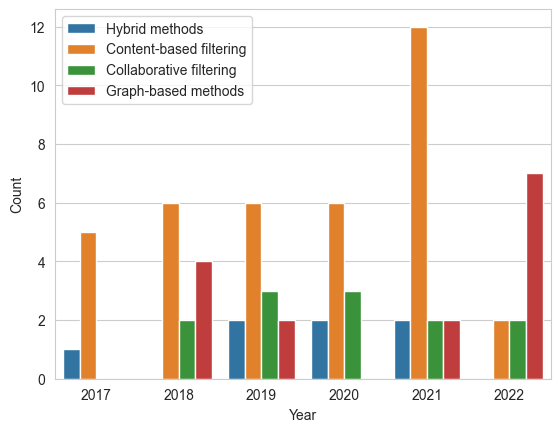

In [150]:
'''
Number of methods proposed each year.
fig:methods_year | methods_year.png
'''
# count number of algorithms per year
method_count = model_data[['Year', 'Method']].value_counts().rename_axis(['Year', 'Method']).reset_index(name='Count').sort_values(by='Year')

# plot
_ = sns.barplot(data=method_count, x='Year', y='Count', hue='Method')
_ = plt.legend(loc='upper left')
plt.savefig('plots/methods_year.png', dpi=dpi)

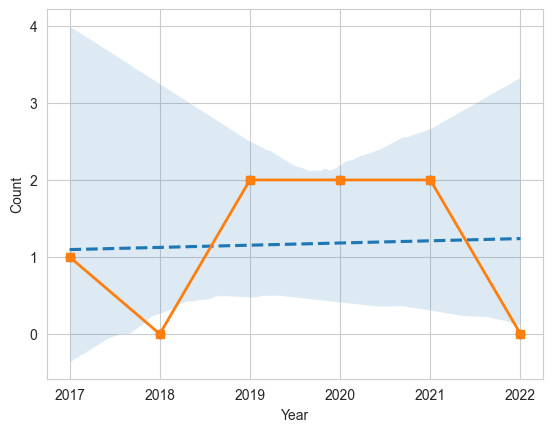

In [151]:
'''
Distribution of hybrid FRS over the years.
fig:hybrid_count | hybrid_count.png
'''
# count the occurence of years
hybrid_count = model_data['Year'][model_data['Method'] == 'Hybrid methods'].value_counts()
hybrid_count.index = hybrid_count.index.astype(int)

# add empty years
hybrid = pd.concat((hybrid_count, pd.Series({2018: 0, 2022: 0}))).sort_index().reset_index()
hybrid.columns = ['Year', 'Count']

# plot
sns.regplot(x='Year', y='Count', data=hybrid, line_kws={'ls': '--'})
_ = plt.plot(hybrid['Year'], hybrid['Count'], 's-', linewidth = 2, markersize=6)
plt.savefig('plots/hybrid_count.png', dpi=dpi)

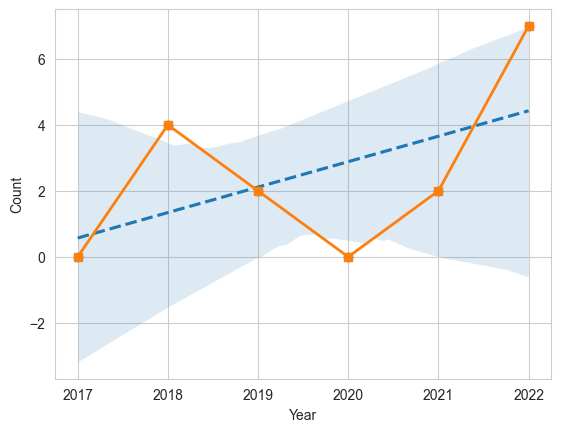

In [152]:
'''
Distribution of graph FRS over the years.
fig:graph_count | graph_count.png
'''
# count the occurence of years
hybrid_count = model_data['Year'][model_data['Method'] == 'Graph-based methods'].value_counts()
hybrid_count.index = hybrid_count.index.astype(int)

# add empty years
hybrid = pd.concat((hybrid_count, pd.Series({2017: 0, 2020: 0}))).sort_index().reset_index()
hybrid.columns = ['Year', 'Count']

# plot
sns.regplot(x='Year', y='Count', data=hybrid, line_kws={'ls': '--'})
_ = plt.plot(hybrid['Year'], hybrid['Count'], 's-', linewidth = 2, markersize=6)
plt.savefig('plots/graph_count.png', dpi=dpi)

/var/folders/nr/th_xmtyd5kx_pj915nblzzsm0000gn/T/ipykernel_32338/488771074.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method_norm['Year'] = method_norm['Year'].astype(int)


Hybrid methods
   Year     Count
0  2017  0.166667
2  2018  0.000000
3  2019  0.153846
5  2020  0.181818
7  2021  0.111111
9  2022  0.000000


/var/folders/nr/th_xmtyd5kx_pj915nblzzsm0000gn/T/ipykernel_32338/488771074.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method_norm['Year'] = method_norm['Year'].astype(int)


Content-based filtering
    Year     Count
0   2017  0.833333
2   2018  0.500000
4   2019  0.461538
6   2020  0.545455
8   2021  0.666667
10  2022  0.181818


/var/folders/nr/th_xmtyd5kx_pj915nblzzsm0000gn/T/ipykernel_32338/488771074.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method_norm['Year'] = method_norm['Year'].astype(int)


Collaborative filtering
   Year     Count
0  2017  0.000000
1  2018  0.166667
3  2019  0.230769
5  2020  0.272727
7  2021  0.111111
9  2022  0.181818


/var/folders/nr/th_xmtyd5kx_pj915nblzzsm0000gn/T/ipykernel_32338/488771074.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method_norm['Year'] = method_norm['Year'].astype(int)


Graph-based methods
   Year     Count
0  2017  0.000000
1  2018  0.333333
3  2019  0.153846
5  2020  0.000000
6  2021  0.111111
8  2022  0.636364


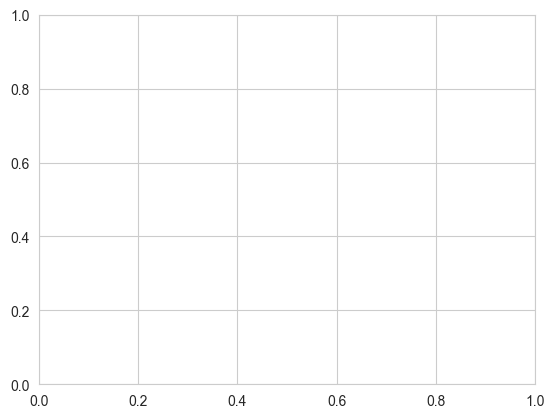

In [153]:
''' Plot showing the relative usage of a specific method
fig:{method}_reluse | {method}_reluse.png '''

# infer relative accounts normalised by year
methods = model_data[['Year', 'Method']]

methods_norm = methods.value_counts().groupby('Year', group_keys=False).apply(lambda x: x/sum(x)).reset_index(name='Count').sort_values(by='Year')

for method in methods['Method'].unique():
    # get normalised count for current method
    method_norm = methods_norm[methods_norm['Method'] == method]
    # convert years to integers
    method_norm['Year'] = method_norm['Year'].astype(int)
    # set years as index
    method_norm = method_norm.set_index('Year')
    # create series containing normalised counts with year as index
    method_norm = pd.Series(method_norm['Count'])

    # placeholder for missing years
    empty_years = pd.Series({2017:0, 2018:0, 2019:0, 2020:0, 2021:0, 2022:0})

    # add placeholder empty years to the normalised counts
    method_norm = pd.concat([method_norm, empty_years]).sort_index().reset_index()
    method_norm.columns = ['Year', 'Count']
    # drop placeholder years that are already in the data
    method_norm = method_norm.drop_duplicates('Year')

    # plot
    ax = sns.regplot(x='Year', y='Count', data=method_norm, line_kws={'ls': '--'})
    _ = plt.plot(method_norm['Year'], method_norm['Count'], 's-', linewidth = 2, markersize=6)
    _ = ax.set_ylabel('Relative frequency')
    plt.savefig('plots/{}_reluse.png'.format(method), dpi=dpi)
    ax.cla()

    print(method)
    print(method_norm)

## Personalisation

In [154]:
print(rq1['Personalisation'].value_counts())
print(rq1['Personalisation'].value_counts(normalize=True))

Not personalised    36
Personalised        35
Name: Personalisation, dtype: int64
Not personalised    0.507042
Personalised        0.492958
Name: Personalisation, dtype: float64


In [155]:
method_pers_count = rq1[['Method', 'Personalisation']].value_counts().sort_index()
print(method_pers_count)

Method                   Personalisation 
Collaborative filtering  Not personalised     3
                         Personalised         9
Content-based filtering  Not personalised    28
                         Personalised         9
Graph-based methods      Not personalised     4
                         Personalised        11
Hybrid methods           Not personalised     1
                         Personalised         6
dtype: int64


In [156]:
for method in rq1['Method'].unique():
    print(method)
    print(rq1['Personalisation'][rq1['Method'] == method].value_counts(normalize=True), end='\n\n')

Hybrid methods
Personalised        0.857143
Not personalised    0.142857
Name: Personalisation, dtype: float64

Content-based filtering
Not personalised    0.756757
Personalised        0.243243
Name: Personalisation, dtype: float64

Collaborative filtering
Personalised        0.75
Not personalised    0.25
Name: Personalisation, dtype: float64

Graph-based methods
Personalised        0.733333
Not personalised    0.266667
Name: Personalisation, dtype: float64



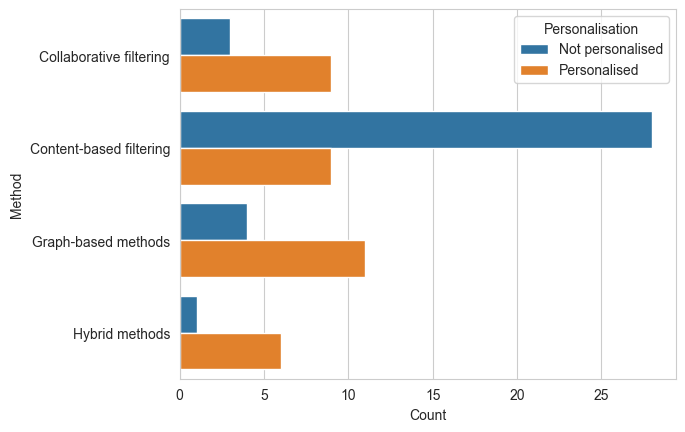

In [157]:
'''
Distribution of personalisation for each method
fig:methods_pers | methods_pers.png
'''

# get counts for each combination of algorithm and personalisation
method_pers_count_df = method_pers_count.rename_axis(['Method', 'Personalisation']).reset_index(name='Count')

# plot personalisation against algorithm used
_ = sns.barplot(data=method_pers_count_df, y='Method', x='Count', hue='Personalisation', orient='horizontal')
plt.savefig('plots/personalisation_method.png', dpi=dpi, bbox_inches='tight')

## Recommendation Algorithm

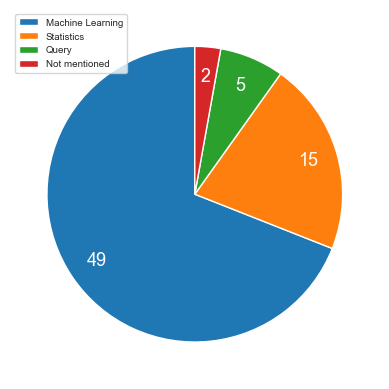

In [158]:
'''
Distribution of the different recommendation algorithms
fig:algorithms | algorithms.png
'''

# count occurences
rec_count = rq1['Algorithm'].value_counts()

# plot
_ = plt.pie(
    x=rec_count.values, 
    autopct=lambda x: '{:.0f}'.format(x*rec_count.values.sum()/100), 
    colors = sns.color_palette()[:5], 
    textprops={'color':"w", 'size': 13}, 
    startangle=90, 
    pctdistance=0.8)
_ = plt.legend(rec_count.index, prop={'size': 7})
plt.savefig('plots/algorithms.png', dpi=dpi)

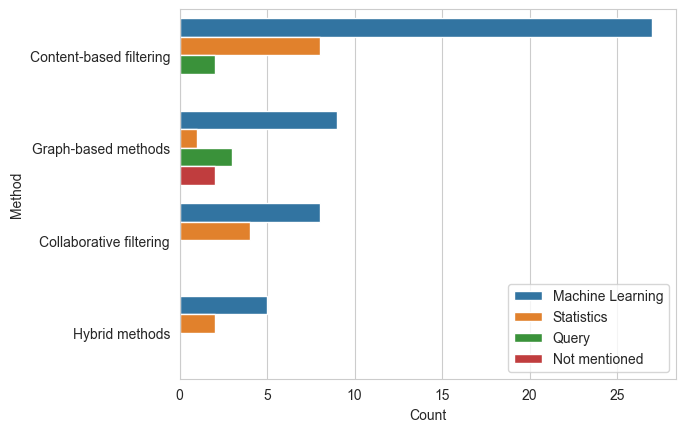

In [159]:
'''
Distribution of recommendation methods for each algorithm
fig:algorithms_method | algorithms_method.png
'''

# get counts for each combination of recommendation method and algorithm
pers_count = rq1[['Method', 'Algorithm']].value_counts().rename_axis(['Method', 'Algorithm']).reset_index(name='Count')

# plot method against algorithm
_ = sns.barplot(data=pers_count, y='Method', x='Count', hue='Algorithm')
_ = plt.legend(loc='lower right')
plt.savefig('plots/algorithms_method.png', dpi=dpi, bbox_inches='tight')

## Combinations

In [160]:
combo = rq1.drop('Year', axis=1)
combo = combo.value_counts().sort_values(ascending=False)
combo.to_csv('tables/combinations.csv')

In [161]:
print(combo)

Method                   Personalisation   Algorithm       
Content-based filtering  Not personalised  Machine Learning    20
Graph-based methods      Personalised      Machine Learning     8
Content-based filtering  Personalised      Machine Learning     7
Collaborative filtering  Personalised      Machine Learning     6
Content-based filtering  Not personalised  Statistics           6
Hybrid methods           Personalised      Machine Learning     5
Collaborative filtering  Personalised      Statistics           3
Graph-based methods      Personalised      Not mentioned        2
                         Not personalised  Query                2
Content-based filtering  Personalised      Statistics           2
                         Not personalised  Query                2
Collaborative filtering  Not personalised  Machine Learning     2
Graph-based methods      Personalised      Query                1
Hybrid methods           Not personalised  Statistics           1
Graph-based meth

# RQ2 What kind of data and preprocessing techniques are used in Food Recommendation Systems?

In [162]:
# read necessary columns
rq3 = model_data.iloc[:, [11] + list(range(18,25))].copy()

## Sources

In [163]:
# make list of sources
rq3['Data source'] = rq3['Data source'].str.split(', ', expand=False)
# get all sources
sources = rq3['Data source'].explode()
# get number of sources for each model
rq3['n sources'] = rq3['Data source'].apply(lambda x: len(x))

In [164]:
# one paper use 
model_data[rq3['n sources'] == 12]

,ID Progress 100%,Title,Date of Extraction,Year,Authors,Publication Venue,Publication Title,Type,Main goal,Personalisation,...,Item representation,Data size,Preprocessing,Repository,External libraries,Domain,Targeted users,Stakeholders,User representation,Number of extraction points: 30
9,ng2017toddlers,Personalized Recipe Recommendations for Toddle...,29.10.22,2017,"Yiu-Kai Ng, Meilan Jin",ACM,MEDES '17: Proceedings of the 9th Internationa...,Conference proceeding,Recommend healthy recipes for toddlers switchi...,Personalised,...,Topic Modelling,10000,Not mentioned,Not mentioned,Not mentioned,Health,Toddlers,Not mentioned,Explicit,0.533333


In [165]:
n_sources = sources.value_counts(normalize=False)
n_sources[n_sources.values > 1]

Allrecipes       21
Food             11
Yummly            8
Recipe1M          8
USDA              5
Kaggle            5
Geniuskitchen     4
Not mentioned     4
Meishijie         4
Go Cooking        3
FoodKG            3
Novel             2
Cooks             2
Epicurious        2
Foodnetwork       2
Name: Data source, dtype: int64

In [166]:
print('Total amount of sources: {}'.format(len(sources.unique())))
print('Amount of sources used once: {}'.format(len(n_sources[n_sources.values ==1])))

Total amount of sources: 48
Amount of sources used once: 33


In [167]:
rq3['n sources'].describe()

count    71.000000
mean      1.647887
std       1.691142
min       1.000000
25%       1.000000
50%       1.000000
75%       2.000000
max      12.000000
Name: n sources, dtype: float64

Number of unique datasets: 46


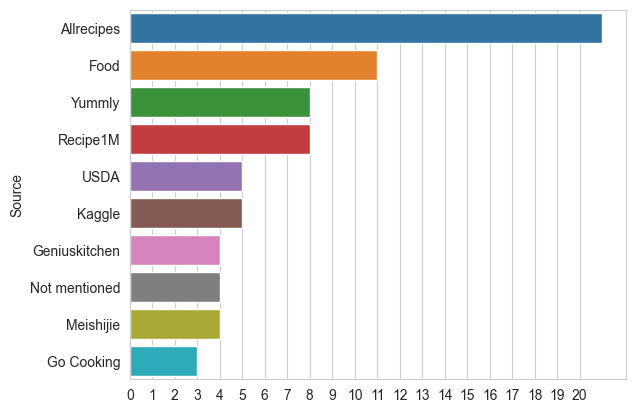

In [168]:
'''
Distribution of times the top ten sources are used.
fig:source_use | source_use.png
'''
# find usage of sources
print('Number of unique datasets:', len(sources.unique())-2)

# get the counts
source_count = sources.value_counts().sort_values(ascending=False)[:10]

# plot
_ = sns.barplot(y=source_count.index, x=source_count.values, orient='h')
_ = plt.ylabel('Source')
_ = plt.xticks(range(21))
plt.savefig('plots/source_use.png', bbox_inches='tight', dpi=dpi)

In [169]:
source_count = pd.DataFrame(sources.value_counts().sort_values(ascending=False))

In [170]:
source_count['perc'] = source_count['Data source'].apply(lambda x: round(x/71*100, 2))

In [171]:
source_count.head(10)

,Data source,perc
Allrecipes,21,29.58
Food,11,15.49
Yummly,8,11.27
Recipe1M,8,11.27
USDA,5,7.04
Kaggle,5,7.04
Geniuskitchen,4,5.63
Not mentioned,4,5.63
Meishijie,4,5.63
Go Cooking,3,4.23


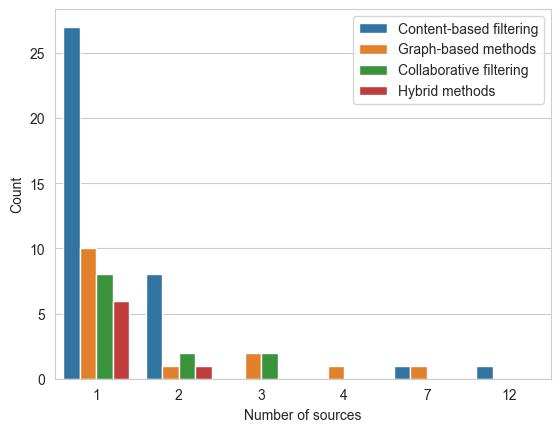

In [172]:
'''
Distribution of number of sources used per method.
fig:source_method | source_method.png
'''

# get counts for each combination of recommendation method and algorithm
sources_method = rq3[['Method', 'n sources']].value_counts().rename_axis(['Method', 'n sources']).reset_index(name='Count')

# plot method against algorithm
_ = sns.barplot(data=sources_method, x='n sources', y='Count', hue='Method')
_ = plt.xlabel('Number of sources')
_ = plt.legend(loc='upper right')
plt.savefig('plots/source_method.png', dpi=dpi)

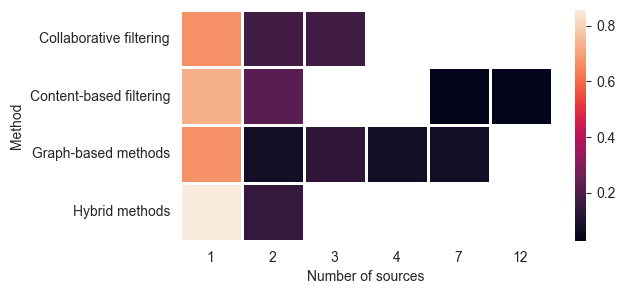

In [173]:
# create pivot table
sources_pivot = sources_method.pivot_table(index='Method', columns='n sources', fill_value=0)
# reorder methods
sources_pivot = sources_pivot

# calculate percentages of sources used PER method
sources_pivot['sum'] = sources_pivot.apply(lambda x: sum(x), axis=1)
sources_pivot = sources_pivot.apply(lambda x: x/sources_pivot['sum'])
sources_pivot = sources_pivot.iloc[:, :-1]

# convert 0 to nan in order to ignore plotting
sources_pivot[sources_pivot == 0] = np.nan

# plot heatmap
fig, ax = plt.subplots(figsize=(6,3))
ax = sns.heatmap(sources_pivot, linewidths=1, ax=ax)
_ = ax.set_xticklabels([1,2,3,4,7,12])
_ = ax.set_xlabel('Number of sources')
plt.savefig('plots/nsources_heat.png', dpi=dpi, bbox_inches='tight')

## Format

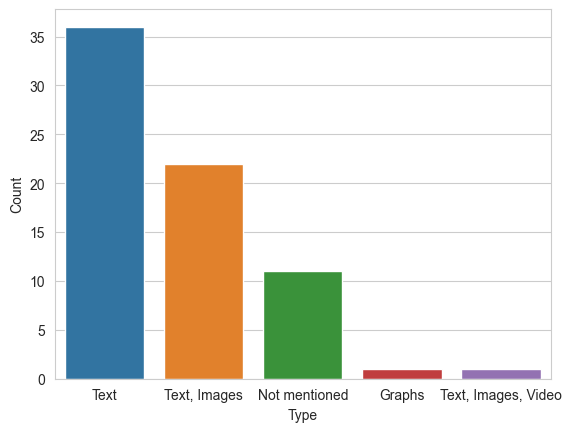

In [174]:
'''
Distribution of different data types by model.
fig:dtypes | dtypes.png
 '''

# get counts of the different types
type_count = rq3['Data format'].value_counts()
_ = sns.barplot(x=type_count.index, y=type_count.values)
_ = plt.xlabel('Type')
_ = plt.ylabel('Count')
plt.savefig('plots/dtypes.png', dpi=dpi)

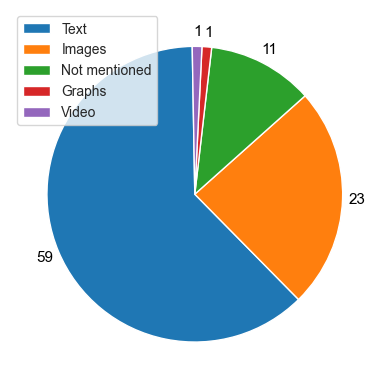

In [175]:
'''
Distribution of different data-types
fig:dtypes2 | dtypes2.png
'''

# get the different types
type_count = rq3['Data format'].str.split(', ').explode().value_counts()

# plot
_ = plt.pie(
    x=type_count.values,
    autopct=lambda x: '{:.0f}'.format(x*type_count.values.sum()/100), 
    colors = sns.color_palette(), 
    textprops={'color':"k", 'size': 11}, 
    startangle=91, 
    pctdistance=1.1,
    )
_ = plt.legend(type_count.index)
plt.savefig('plots/dtypes2.png', dpi=dpi)

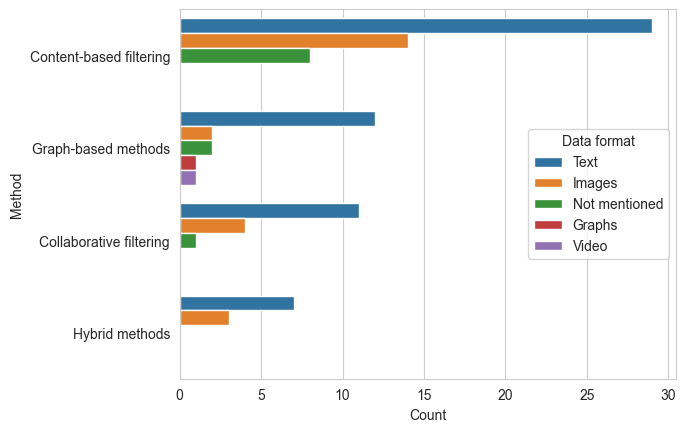

In [176]:
'''
Distribution of data formats for each method
fig:dtypes_method | dtypes_method.png
'''

# count each combination of data type and algorithm
dtype_algo = rq3[['Data format', 'Method']].copy()
dtype_algo['Data format'] = dtype_algo['Data format'].str.split(', ', expand=False)
dtype_algo_count = dtype_algo.explode('Data format').value_counts().rename_axis(['Data format', 'Method']).reset_index(name='Count')

# plot method against algorithm
_ = sns.barplot(data=dtype_algo_count, y='Method', x='Count', hue='Data format')
plt.savefig('plots/dtypes_method.png', dpi=dpi, bbox_inches='tight')

## Size

In [177]:
# get sizes, find number of missing values
size = rq3['Data size']
print('Systems with size not mentioned: {}'.format(len(rq3[rq3['Data size'] == 'Not mentioned'])))

# remove missing values, convert type to integer
size = rq3['Data size'][rq3['Data size'] != 'Not mentioned'].astype(np.int32)

# get the median size
print('Median size of dataset:', size.median())

Systems with size not mentioned: 13
Median size of dataset: 61139.0


In [178]:
size.describe()

count    5.800000e+01
mean     5.858302e+05
std      2.322168e+06
min      1.050000e+02
25%      3.121125e+04
50%      6.113900e+04
75%      2.308760e+05
max      1.600000e+07
Name: Data size, dtype: float64

In [179]:
# look at the largest datasets
size.sort_values(ascending=False).head()

54    16000000
51     8100000
3      1029720
66     1029720
4      1000000
Name: Data size, dtype: int32

In [180]:
rq3[rq3['Data size'] != 'Not mentioned'][size > 1029720]

,Method,Comparison,Data source,Data format,Data attributes,Item representation,Data size,Preprocessing,n sources
51,Hybrid methods,Several popular baselines,[Cookpad],"Text, Images","Ingredients, Cooking Instructions, Images, Por...","TF-IDF, Vectorisation",8100000,Text-cleaning,1
54,Content-based filtering,"Collaborative topic Poisson factorization, Wor...",[LoseIt! Diet tracking app.],Text,Ingredients,Matrix,16000000,Exclusion,1


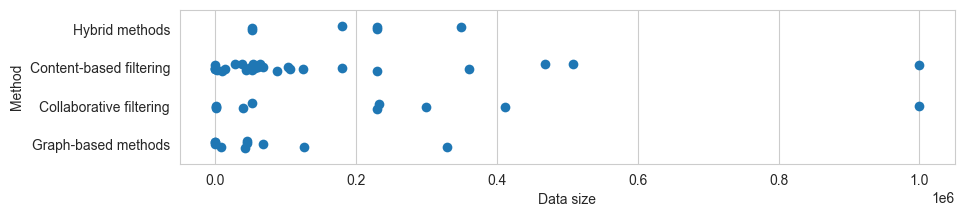

In [181]:
'''
Distribution of data size for each method
fig:dsize_method | dsize_method.png
'''

# get counts for each combination of recommendation method and algorithm
dsize_method = rq3[['Data size', 'Method']]
dsize_method = dsize_method[dsize_method['Data size'] != 'Not mentioned'][size < 1029720]
dsize_method['Data size'] = dsize_method['Data size'].astype(np.int32)

# plot size against method
_ = plt.subplots(figsize = (10, 2))
_ = sns.stripplot(data=dsize_method, y='Method', x='Data size', size=7, marker='o')
plt.savefig('plots/dsize_method.png', bbox_inches='tight', dpi=dpi)

In [182]:
len(rq3[rq3['Data size'] == 'Not mentioned'])

13

In [183]:
# describe the different datasets per method
for method in dsize_method['Method'].unique():
    print(method)
    print(dsize_method[dsize_method['Method'] == method]['Data size'].describe())

Hybrid methods
count         6.000000
mean     182719.000000
std      115461.390004
min       52281.000000
25%       84210.750000
50%      205438.000000
75%      230876.000000
max      350000.000000
Name: Data size, dtype: float64
Content-based filtering
count         28.000000
mean      135039.000000
std       216069.561151
min          105.000000
25%        25455.000000
50%        58818.500000
75%       111487.000000
max      1000000.000000
Name: Data size, dtype: float64
Collaborative filtering
count         10.000000
mean      227122.200000
std       308306.564805
min         1169.000000
25%        11143.500000
50%       141578.500000
75%       283112.500000
max      1000000.000000
Name: Data size, dtype: float64
Graph-based methods
count        10.000000
mean      67008.100000
std      100447.204409
min         289.000000
25%        2850.250000
50%       44451.000000
75%       63003.000000
max      330102.000000
Name: Data size, dtype: float64


## Attributes

In [184]:
# count attributes
rq3['Data attributes'].str.split(', ', expand=False).explode().value_counts()

Ingredients             58
Cooking Instructions    37
Title                   30
Images                  25
Nutrition               20
Ratings                 19
Not mentioned           10
Interactions             8
Cuisine                  8
Flavour                  7
Portions                 6
Quantity                 5
Users                    5
Context                  4
Diet                     3
Equipment                3
Pairings                 2
Tags                     2
Course                   2
Restaurants              1
Transactions             1
Authors                  1
Time                     1
Calories                 1
Name: Data attributes, dtype: int64

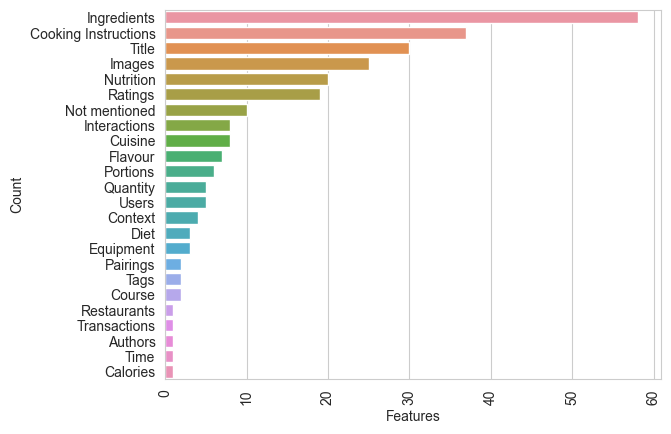

In [185]:
'''
Distribution of used features in the dataset
fig:dfeatures | dfeatures.png
'''
# split several features into separate rows
features = rq3['Data attributes'].str.split(', ', expand=False).explode()
features = features.value_counts()

# plot
_ = sns.barplot(x=features.values, y=features.index)
_ = plt.xlabel('Features')
_ = plt.ylabel('Count')
_ = plt.xticks(rotation=90)
plt.savefig('plots/dfeatures.png', bbox_inches='tight', dpi=dpi)

In [186]:
# get overall distribution of the number of attributes that are considered
# get attributes and method
attributes = rq3[['Data attributes', 'Method']]

# replace not mentioned with NA and convert to list
attributes['Data attributes'] = attributes['Data attributes'].replace('Not mentioned', np.nan).str.split(', ')

# count number of attributes per list
attributes['n'] = attributes['Data attributes'].apply(lambda x: len(x) if type(x) == list else 0)

/var/folders/nr/th_xmtyd5kx_pj915nblzzsm0000gn/T/ipykernel_32338/4174602603.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  attributes['Data attributes'] = attributes['Data attributes'].replace('Not mentioned', np.nan).str.split(', ')
/var/folders/nr/th_xmtyd5kx_pj915nblzzsm0000gn/T/ipykernel_32338/4174602603.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  attributes['n'] = attributes['Data attributes'].apply(lambda x: len(x) if type(x) == list else 0)


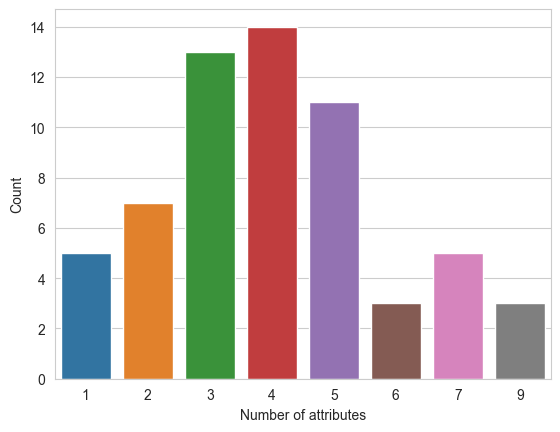

In [187]:
# plot the overall distribution of number of attributes used
n_attributes = attributes['n'].value_counts().sort_index().iloc[1:]

ax = sns.barplot(x=n_attributes.index, y=n_attributes.values)
_ = ax.set_ylabel('Count')
_ = ax.set_xticklabels([1,2,3,4,5,6,7,9], rotation=0)
_ = ax.set_xlabel('Number of attributes')
plt.savefig('plots/nattributes.png', dpi=dpi)

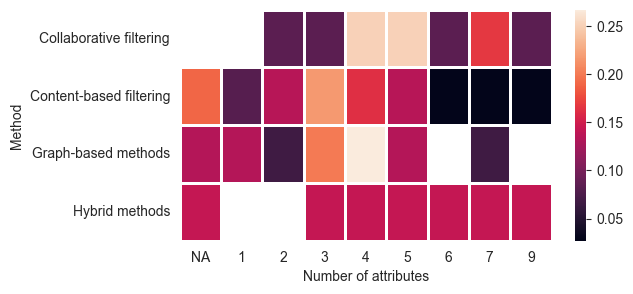

In [188]:
# count the distribution of number of attributes used per method, create df
n_attributes = attributes[['Method', 'n']].value_counts().rename_axis(['Method', 'n']).reset_index(name='Count')

# create pivot table of df
n_attributes_pivot = n_attributes.pivot_table(index='Method', columns='n', fill_value=0)

# reorder methods
n_attributes_pivot = n_attributes_pivot

# calculate sum of each row of source counts (per method)
n_attributes_pivot['sum'] = n_attributes_pivot.apply(lambda x: sum(x), axis=1)

# calculate percentage and remove sum column
n_attributes_pivot = n_attributes_pivot.apply(lambda x: x/n_attributes_pivot['sum'])
n_attributes_pivot = n_attributes_pivot.iloc[:, :-1]

# convert 0 to nan in order to ignore plotting
n_attributes_pivot[n_attributes_pivot == 0] = np.nan

# plot heatmap
fig, ax = plt.subplots(figsize=(6,3))
ax = sns.heatmap(n_attributes_pivot, linewidths=1, ax=ax)
ax.set_xticklabels(['NA',1,2,3,4,5,6,7,9], rotation=0)
ax.set_xlabel('Number of attributes')
plt.savefig('plots/nattributes_heat.png', dpi=dpi, bbox_inches='tight')

## Representation

In [189]:
representation = rq3['Item representation'].str.split(', ').explode()
len(representation.unique())

8

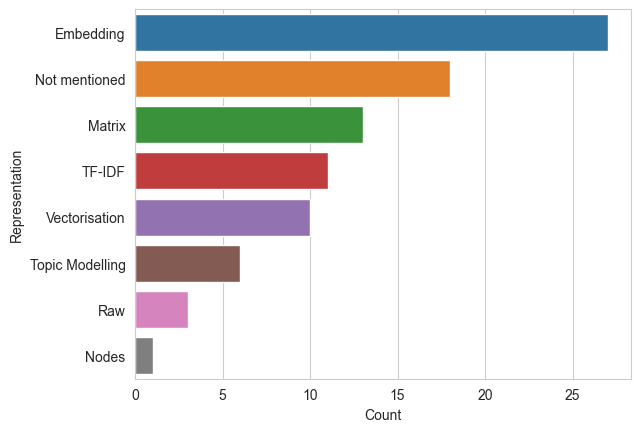

In [190]:
'''
Distribution of representation of dataset
fig:drepresent | drepresent.png
'''
# split several features into separate rows
d_rep = rq3['Item representation'].str.split(', ', expand=False).explode()
d_rep = d_rep.value_counts()

# plot
_ = sns.barplot(y=d_rep.index, x=d_rep.values)
_ = plt.xlabel('Count')
_ = plt.ylabel('Representation')
plt.savefig('plots/drepresent.png', bbox_inches='tight', dpi=dpi)

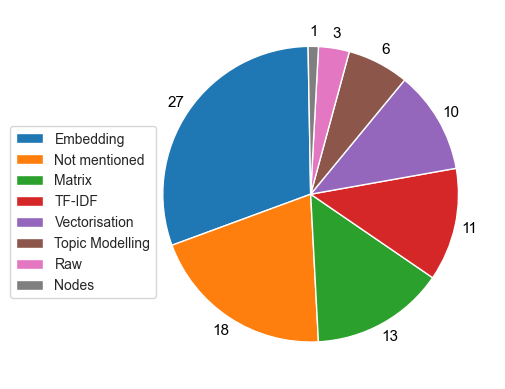

In [191]:
'''
Distribution of representation of data-set
fig:drepresent2 | drepresent2.png
'''
# split several features into separate rows
d_rep = rq3['Item representation'].str.split(', ', expand=False).explode()
d_rep = d_rep.value_counts()

# plot
_ = plt.pie(
    x=d_rep.values,
    autopct=lambda x: '{:.0f}'.format(x*d_rep.values.sum()/100), 
    textprops={'color':"k", 'size': 11}, 
    startangle=91, 
    pctdistance=1.1,
    )

#_ = sns.barplot(x=d_proc.index, y=d_proc.values)
_ = plt.legend(d_rep.index, loc='lower right', bbox_to_anchor=(0.1, 0.2))
_ = plt.xticks(rotation=90)
plt.savefig('plots/drepresent2.png', bbox_inches='tight', dpi=dpi)

## Preprocessing

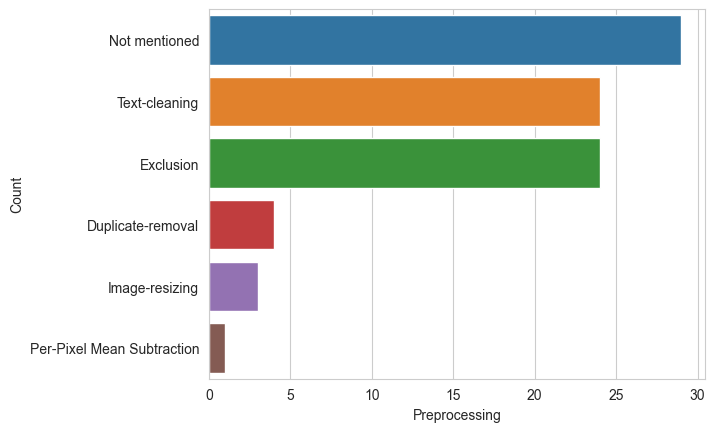

In [192]:
'''
Distribution of preprocessing of data-set
fig:dprocess | dprocess.png
'''
# split several features into separate rows
d_proc = rq3['Preprocessing'].str.split(', ', expand=False).explode()
d_proc = d_proc.value_counts()

# plot
_ = sns.barplot(x=d_proc.values, y=d_proc.index)
_ = plt.xlabel('Preprocessing')
_ = plt.ylabel('Count')
plt.savefig('plots/dprocess.png', bbox_inches='tight', dpi=dpi)

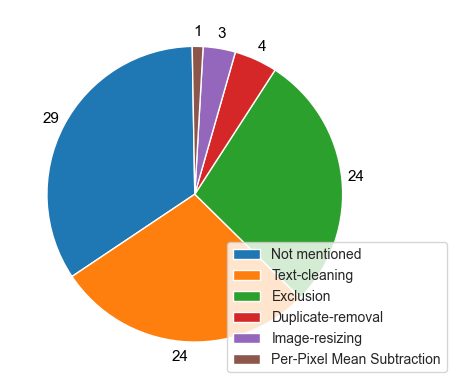

In [193]:
'''
Distribution of preprocessing of dataset
fig:dprocess | dprocess.png
'''
# split several features into separate rows
d_proc = rq3['Preprocessing'].str.split(', ', expand=False).explode()
d_proc = d_proc.value_counts()

# plot
_ = plt.pie(
    x=d_proc.values,
    autopct=lambda x: '{:.0f}'.format(x*d_proc.values.sum()/100), 
    textprops={'color':"k", 'size': 11}, 
    startangle=91, 
    pctdistance=1.1,
    )

#_ = sns.barplot(x=d_proc.index, y=d_proc.values)
_ = plt.legend(d_proc.index, loc='lower right', bbox_to_anchor=(1.2, 0))
_ = plt.xticks(rotation=90)
plt.savefig('plots/dprocess2.png', bbox_inches='tight', dpi=dpi)

# RQ3 How are the Food Recommendation Systems evaluated?

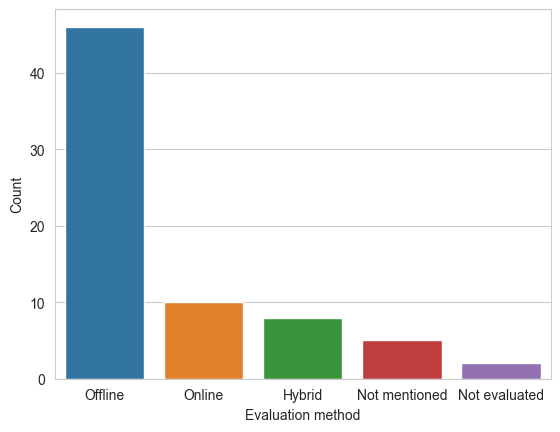

In [194]:
'''
Distribution of evaluation methods from the collected frs.
fig:eval | eval.png
'''

eval_meth_count = model_data['Evaluation'].value_counts()
_ = sns.barplot(x=eval_meth_count.index, y=eval_meth_count.values)
_ = plt.xlabel('Evaluation method')
_ = plt.ylabel('Count')
plt.savefig('plots/eval.png', dpi=dpi)

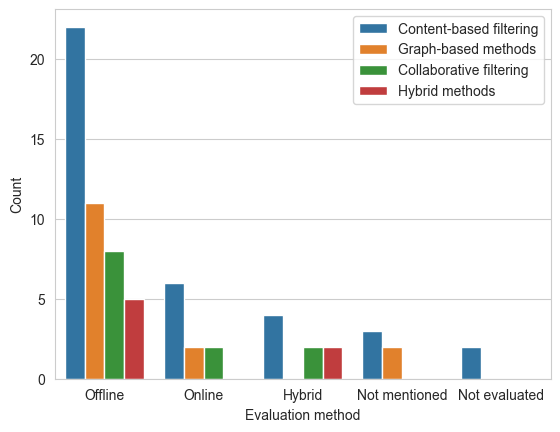

In [195]:
'''
Distribution of evaluation methods from the collected frs by method.
fig:eval_method | eval_method.png
'''

eval_meth_algo_count = model_data[['Evaluation', 'Method']].value_counts().rename_axis(['Evaluation', 'Method']).reset_index(name='Count')
_ = sns.barplot(data=eval_meth_algo_count, x='Evaluation', y='Count', hue='Method')
_ = plt.legend(loc='upper right')
_ = plt.xlabel('Evaluation method')
_ = plt.ylabel('Count')
plt.savefig('plots/eval_method.png', dpi=dpi, bbox_inches='tight')

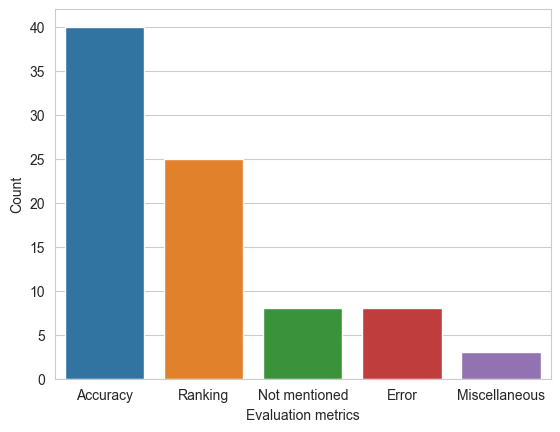

In [196]:
'''
The distribution of evaluation metrics.
fig:metrics | metrics.png
'''

# get all the different metrics used
metrics = model_data['Metrics'][model_data['Evaluation'] != 'Online'].str.split(', ').explode().value_counts()

# plot distribution
_ = sns.barplot(x=metrics.index, y=metrics.values)
_ = plt.xlabel('Evaluation metrics')
_ = plt.ylabel('Count')
plt.savefig('plots/metrics.png', dpi=dpi)

In [197]:
print(model_data['Metrics'][model_data['Evaluation'] != 'Online'].str.split(', ').explode().value_counts())

Accuracy         40
Ranking          25
Not mentioned     8
Error             8
Miscellaneous     3
Name: Metrics, dtype: int64


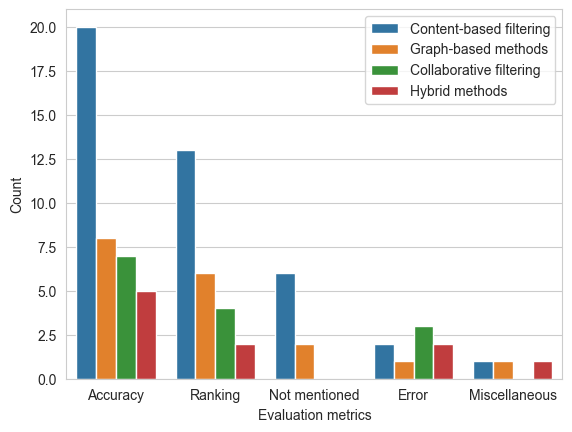

In [198]:
'''
The distribution of evaluation metrics based on method.
fig:metrics_method | metrics_method.png
'''

# get all the different metrics used
metrics = model_data[['Metrics', 'Method']][model_data['Evaluation'] != 'Online']
metrics['Metrics'] = metrics['Metrics'].str.split(', ')
metrics = metrics.explode('Metrics').value_counts()
metrics = metrics.rename_axis(['Metrics', 'Method']).reset_index(name='Count')

# plot distribution
_ = sns.barplot(data=metrics, x='Metrics', y='Count', hue='Method')
_ = plt.xlabel('Evaluation metrics')
_ = plt.ylabel('Count')
_ = plt.legend(loc='upper right')
plt.savefig('plots/metrics_method.png', dpi=dpi, bbox_inches='tight')


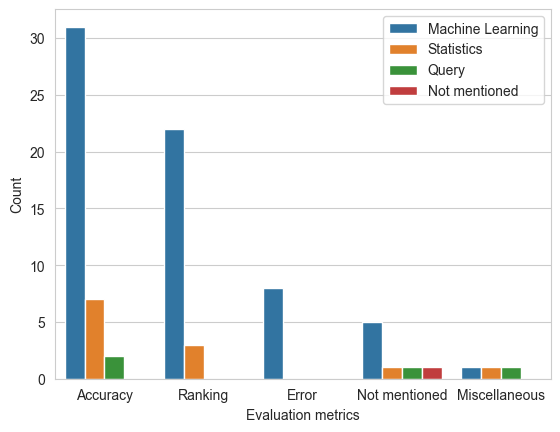

In [199]:
'''
The distribution of evaluation metrics based on algorithm.
fig:metrics_algorithm | metrics_algorithm.png
'''

# get all the different metrics used
metrics = model_data[['Metrics', 'Algorithm']][model_data['Evaluation'] != 'Online']
metrics['Metrics'] = metrics['Metrics'].str.split(', ')
metrics = metrics.explode('Metrics').value_counts()
metrics = metrics.rename_axis(['Metrics', 'Algorithm']).reset_index(name='Count')

# plot distribution
_ = sns.barplot(data=metrics, x='Metrics', y='Count', hue='Algorithm')
_ = plt.xlabel('Evaluation metrics')
_ = plt.ylabel('Count')
_ = plt.legend(loc='upper right')
plt.savefig('plots/metrics_algorithm.png', dpi=dpi)


# RQ4 How many recent scientific studies on Food Recommendation Systems are open source?

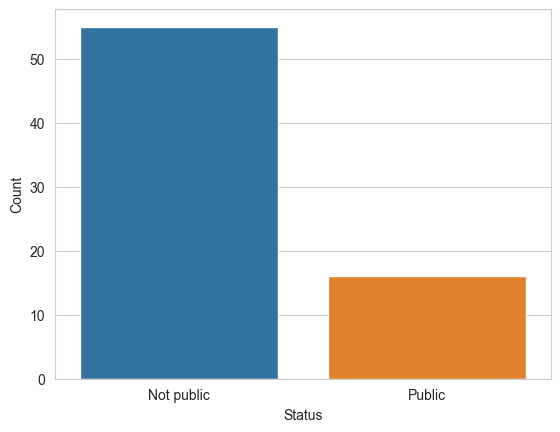

In [200]:
'''Plot number of public and not-public frs.
fig:public_frs | public_frs.png '''

# change '-' into Not public
public = model_data['Repository'].str.replace('Not mentioned', 'Not public')
# if link is present, the frs is made Public
public = public.str.replace('^https.*', 'Public', regex=True)
public_count = public.value_counts()

# plot
_ = sns.barplot(x=public_count.index, y=public_count.values)
_ = plt.ylabel('Count')
_ = plt.xlabel('Status')
plt.savefig('plots/public_frs.png', dpi=dpi)

In [201]:
# look to see if there is a connection between algorithm and open source
model_data['Algorithm'][public == 'Public'].value_counts()

Machine Learning    13
Query                2
Statistics           1
Name: Algorithm, dtype: int64

/var/folders/nr/th_xmtyd5kx_pj915nblzzsm0000gn/T/ipykernel_32338/2546724033.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  public['Repository'] = public['Repository'].str.replace('Not mentioned', 'Not available')
/var/folders/nr/th_xmtyd5kx_pj915nblzzsm0000gn/T/ipykernel_32338/2546724033.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  public['Repository'] = public['Repository'].str.replace('^https.*', 'Available', regex=True)


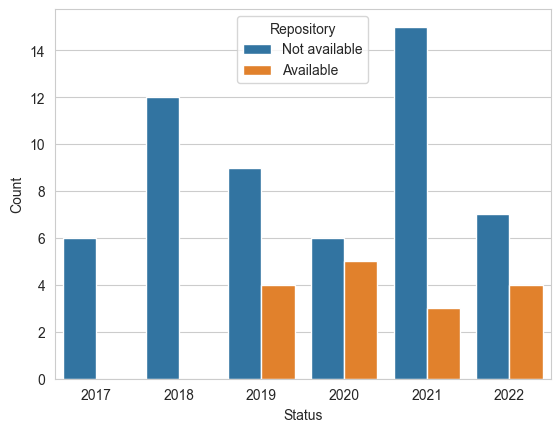

In [202]:
'''Plot number of public and not-public frs over the years.
fig:public_years | public_years.png '''

# change '-' into Not public
public = model_data[['Year', 'Repository']]
public['Repository'] = public['Repository'].str.replace('Not mentioned', 'Not available')
# if link is present, the frs is made Public
public['Repository'] = public['Repository'].str.replace('^https.*', 'Available', regex=True)
public_count = public.value_counts().rename_axis(['Year', 'Repository']).reset_index(name='Count').sort_values(by='Year')

# plot
_ = sns.barplot(data=public_count, x='Year', y='Count', hue='Repository')
_ = plt.ylabel('Count')
_ = plt.xlabel('Status')
plt.savefig('plots/public_years.png', dpi=dpi)

/var/folders/nr/th_xmtyd5kx_pj915nblzzsm0000gn/T/ipykernel_32338/3210685368.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  public['Year'] = public['Year'].astype(int)
/var/folders/nr/th_xmtyd5kx_pj915nblzzsm0000gn/T/ipykernel_32338/3210685368.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  public['Repository'] = public['Repository'].str.replace('Not mentioned', 'Not available')
/var/folders/nr/th_xmtyd5kx_pj915nblzzsm0000gn/T/ipykernel_32338/3210685368.py:10: SettingWithCopyWarning: 
A value is try

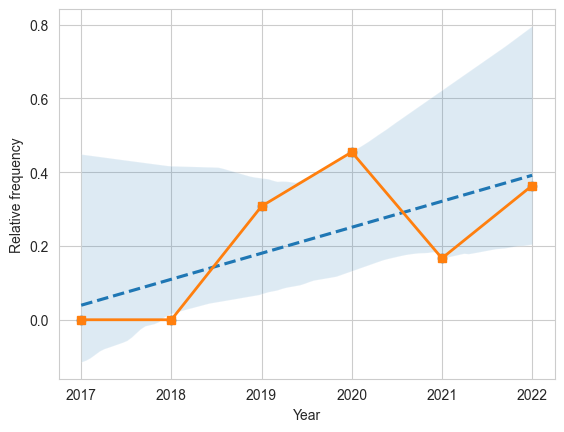

In [203]:
''' Plot showing the number of public FRS relative to the year
fig:public_years2 | public_years2.png '''

# convert data into correct format
public = model_data[['Year', 'Repository']]
public['Year'] = public['Year'].astype(int)
# if link is not mentioned, it is not public
public['Repository'] = public['Repository'].str.replace('Not mentioned', 'Not available')
# if link is present, the frs is made Public
public['Repository'] = public['Repository'].str.replace('^https.*', 'Available', regex=True)

# get the counts relative to the year (each year sums up to 1)
public_norm = public.value_counts().groupby('Year', group_keys=False).apply(lambda x: x/sum(x)).reset_index(name='Count').sort_values(by='Year')

# get the public FRS
public_norm = public_norm[['Year', 'Count']][public_norm['Repository'] == 'Available']

# add empty years
empty_years = pd.DataFrame(
    ((2017, 0.),
     (2018, 0.),
     (2019, 0.),
     (2020, 0.),
     (2021, 0.),
     (2022, 0.),
     ), columns=('Year', 'Count')
)

# add placeholder empty years to the normalised counts
public_norm = pd.concat([public_norm, empty_years])
# drop placeholder years that are already in the data
public_norm = public_norm.drop_duplicates('Year').sort_values(by='Year')

ax = sns.regplot(x='Year', y='Count', data=public_norm, line_kws={'ls': '--'})
_ = plt.plot(public_norm['Year'], public_norm['Count'], 's-', linewidth = 2, markersize=6)
_ = ax.set_ylabel('Relative frequency')
plt.savefig('plots/public_years2.png', dpi=dpi)

In [204]:
public_norm['Count'] = public_norm['Count'].apply(lambda x: round(x*100, 2))
public_norm

,Year,Count
0,2017,0.00
1,2018,0.00
7,2019,30.77
6,2020,45.45
9,2021,16.67
8,2022,36.36


# RQ5 What are the advantages and disadvantages of Food Recommendation Systems?

In [205]:
# get necessary columns
paper_data = paper_data.rename(columns={
    'ID                                       Progress 100%': 'ID'
    })

## Advantages

By manually assessing the advantages of the primary studies from the extraction form, three categories are found.

In [206]:
# select papers specifying advantages
advantages = paper_data[['ID', 'Main goal', 'Advantages']][paper_data['Advantages'] != 'Not mentioned']

In [207]:
# papers stating advantages
print(len(advantages), round(len(advantages)/len(paper_data)*100, 2))
advantages

63 94.03


,ID,Main goal,Advantages
1,bianchini2017prefer,Build a FRS that provides personalised and hea...,"Improves eating habits, associates prescriptio..."
2,chen2017crossmodal,Use deep learning techniques to retrieve text ...,Needs less training data and less parameters a...
3,chen2018crossmodal,Use recipe-sites to make a model that links im...,"Attention mechanism, unified way of handling t..."
4,chen2021questionAnswering,Give personalized and healthy food recommendat...,"Question recommendations, KG-augmentation and ..."
5,ivacscu2018diseaseDriven,Recommend food based on medical and nutritiona...,Integration of a hospital information system (...
...,...,...,...
61,lee2020recipeGeneration,Generate method based on recipe title and ingr...,"Automatic recipe generation, Automatic evaluat..."
62,liu2018alternative,Alternative ingredient substitution based on c...,Considers novelty and diversity
64,majumder2019historicalPreferences,"Generate a personalised recipe based on title,...","Personalised recipe generation, Novel dataset,..."
65,park2021flavorGraph,Graph embedding of ingredients and chemical co...,Food-specialised Graph-embedding method


In [208]:
# select papers stating rich attributes/multi-modal
papers = [
    'chen2018crossmodal',
    'meng2020visually',
    'min2017delicious',
    'ng2017toddlers',
    'jin2020restaurantAware',
    'gallo2022reducingWater',
    'lei2021knowledgeGraph',
    'li2018consumers',
    'min2018richrecipe',
    'ribeiro2017sousChef',
    'rostami2022timeAware',
    'chen2017crossRetrieval',
    'maia2018contextAware',
    'adaji2018networkGraphs',
    'khan2019ensemble',
    'salvador2019inverseCooking',
    'khan2021complexity'
    ]

rich = advantages.loc[advantages['ID'].isin(papers)]
print(len(rich), round(len(rich)/len(paper_data)*100, 2))
rich

17 25.37


,ID,Main goal,Advantages
3,chen2018crossmodal,Use recipe-sites to make a model that links im...,"Attention mechanism, unified way of handling t..."
7,meng2020visually,Learn an image encoder in order to simultaniou...,Learn visual features of images to give recomm...
8,min2017delicious,Incorporates diverse multi-modal attributes.,Utilises various attributes and multi-modal in...
9,ng2017toddlers,Recommend healthy recipes for toddlers switchi...,"Specific age-group, topic analysis of recipes,..."
15,jin2020restaurantAware,Predict user-preferences for dishes in a speci...,"Recommender system for restaurant-dishes, data..."
24,gallo2022reducingWater,Personalised food recommendations considering ...,"Embeds water-footprint,"
27,khan2021complexity,Use ensemble topic modeling to support persona...,"Identifies multi-domain Food-Features, reduced..."
28,lei2021knowledgeGraph,Provide recipe recommendations accompanied wit...,"Uses multi-modality to improve performance, ap..."
29,li2018consumers,"Predict user-preferences based on history, dis...",Presents a multi-attribute relation matrix tri...
32,min2018richrecipe,Investigate culinary cultures of different cou...,Multi-modal data


In [209]:
for id, goal, adv in zip(rich.iloc[:, 0], rich.iloc[:, 1], rich.iloc[:, 2]):
    print(id)
    print(goal)
    print(adv, end='\n\n')

chen2018crossmodal
Use recipe-sites to make a model that links images to recipes, in order to determine the nutritional content.
Attention mechanism, unified way of handling three levels of recipe, Gated Recurrent Units

meng2020visually
Learn an image encoder in order to simultaniously predict ingredients and recommend food.
Learn visual features of images to give recommendations, able to perform joint training for prediction and recommendation, new dataset on Chinese cuisine

min2017delicious
Incorporates diverse multi-modal attributes.
Utilises various attributes and multi-modal information.

ng2017toddlers
Recommend healthy recipes for toddlers switching from a milk diet to reduce bias introduced by parents own food preference, and introduce healthy eating habits.
Specific age-group, topic analysis of recipes, sentiment analysis of reviews

jin2020restaurantAware
Predict user-preferences for dishes in a specific restaurant.
Recommender system for restaurant-dishes, dataset, conside

In [210]:
papers = [
    'bianchini2017prefer',
    'ivascu2018diseaseDriven',
    'song2022selfSupervised',
    'starke2021differentGoals',
    'nirmal2018optimization',
    'clunis2019hypertensive',
    'mckensy2022ontology',
    'chavan2021bigData',
    'pecune2020healthyPersonalised',
    'ng2017toddlers',
    'li2022graph',
    'chen2021questionAnswering'
]

nutrition = advantages.loc[advantages['ID'].isin(papers)]
print(len(nutrition), round(len(nutrition)/len(paper_data)*100, 2))
nutrition

10 14.93


,ID,Main goal,Advantages
1,bianchini2017prefer,Build a FRS that provides personalised and hea...,"Improves eating habits, associates prescriptio..."
4,chen2021questionAnswering,Give personalized and healthy food recommendat...,"Question recommendations, KG-augmentation and ..."
9,ng2017toddlers,Recommend healthy recipes for toddlers switchi...,"Specific age-group, topic analysis of recipes,..."
10,song2022selfSupervised,Create a Graph network for food recommendation...,Self-supervised learning models ingredient-rel...
11,starke2021differentGoals,"Create a multi-list (less kcals, more fiber, l...","Multi-list increases diversity, explanations b..."
18,nirmal2018optimization,Recommend healthier ingredients that have simi...,Nutrition guided ingredient substitution.
23,clunis2019hypertensive,Create an ontology to answer specific question...,"Aimed at hypertensive individuals, extendable ..."
31,mckensy2022ontology,Recommend diets based on users' BMI.,Recommends diets based on BMI-status
39,chavan2021bigData,Develop three approaches for analysing data in...,"Compares three models, Calculates calorie-inta..."
46,pecune2020healthyPersonalised,Compare three models with different levels of ...,"Combines health with personalisation,"


In [211]:
for id, goal, adv in zip(nutrition.iloc[:, 0], nutrition.iloc[:, 1], nutrition.iloc[:, 2]):
    print(id)
    print(goal)
    print(adv, end='\n\n')

bianchini2017prefer
Build a FRS that provides personalised and healthy menus, taking users preferences and medical prescriptions (made by doctors) into account.
Improves eating habits, associates prescription types with users, uses seasons, adjustable weights for personalisation and prescription.

chen2021questionAnswering
Give personalized and healthy food recommendations (answers) based on natural language questions. Proposes pFoodReq.
Question recommendations, KG-augmentation and Constraint-modeling, QA-style benchmark

ng2017toddlers
Recommend healthy recipes for toddlers switching from a milk diet to reduce bias introduced by parents own food preference, and introduce healthy eating habits.
Specific age-group, topic analysis of recipes, sentiment analysis of reviews

song2022selfSupervised
Create a Graph network for food recommendation, that takes ingredient-relationships and calorie-preference into mind.
Self-supervised learning models ingredient-relations, includes calorie-prefe

In [212]:
', '.join(papers)

'bianchini2017prefer, ivascu2018diseaseDriven, song2022selfSupervised, starke2021differentGoals, nirmal2018optimization, clunis2019hypertensive, mckensy2022ontology, chavan2021bigData, pecune2020healthyPersonalised, ng2017toddlers, li2022graph, chen2021questionAnswering'

In [213]:
papers = [
    'chen2021questionAnswering',
    'mendes2021chat',
    'guidotti2020nextBasket',
    'haussmann2019foodKG',
    'khilji2021cookingQA',
    'starke2021differentGoals',
    'pecune2022persuasive',
    'lei2021knowledgeGraph'
    ]

interaction = advantages.loc[advantages['ID'].isin(papers)]
print(len(interaction), round(len(interaction)/len(paper_data)*100, 2))
interaction

8 11.94


,ID,Main goal,Advantages
4,chen2021questionAnswering,Give personalized and healthy food recommendat...,"Question recommendations, KG-augmentation and ..."
6,mendes2021chat,Build a chatbot for recipe recommendation to p...,A chatbot providing recommendations in a human...
11,starke2021differentGoals,"Create a multi-list (less kcals, more fiber, l...","Multi-list increases diversity, explanations b..."
14,guidotti2020nextBasket,Recommend list of items to purchase based on e...,"Provides explanations for recommendations, ass..."
28,lei2021knowledgeGraph,Provide recipe recommendations accompanied wit...,"Uses multi-modality to improve performance, ap..."
41,haussmann2019foodKG,Design a knowledge Graph to give QA recipe rec...,"Question recommendations, Different datasets, ..."
47,pecune2022persuasive,Conversational recommender system to nudge use...,"Nudges towards health,"
60,khilji2021cookingQA,Threshold based recipe recommendation based on...,Recommends based on questions


In [214]:
for id, goal, adv in zip(interaction.iloc[:, 0], interaction.iloc[:, 1], interaction.iloc[:, 2]):
    print(id)
    print(goal)
    print(adv, end='\n\n')

chen2021questionAnswering
Give personalized and healthy food recommendations (answers) based on natural language questions. Proposes pFoodReq.
Question recommendations, KG-augmentation and Constraint-modeling, QA-style benchmark

mendes2021chat
Build a chatbot for recipe recommendation to provide a human-like experience.
A chatbot providing recommendations in a human-like way

starke2021differentGoals
Create a multi-list (less kcals, more fiber, lactose free etc.) interface for food recommendation along with explanations, and evaluate thorugh a user-centric approach.
Multi-list increases diversity, explanations boosts understandability, highlights nutrient-specific goals

guidotti2020nextBasket
Recommend list of items to purchase based on earlier purchases and identified representative recipes.
Provides explanations for recommendations, assigns purchases to ingredients, outperforms baseline

lei2021knowledgeGraph
Provide recipe recommendations accompanied with rational explanations gen

## Disadvantages/limitations

In [215]:
# select papers specifying disadvantages
disadv = paper_data[['ID', 'Main goal', 'Inferred limitations', 'Stated limitations']]
disadv = disadv[(disadv['Inferred limitations'] != 'Not mentioned') | (disadv['Stated limitations'] != 'Not mentioned')]

In [216]:
print(len(disadv), round(len(disadv)/len(paper_data)*100, 2))

47 70.15


In [217]:
papers = [
    'chen2021questionAnswering',
    'haussmann2019foodKG',
    'garrido2018bayesian',
    'min2017delicious',
    'bajaj2018graphDB',
    'zhang2019hybrid',
    'maia2018contextAware',
    'liu2018alternative',
    'shchuka2020dishID',
    'clunis2019hypertensive',
    'li2018consumers',
    'maheshwari2019recipeRecommendation'
    ]

data = disadv.loc[disadv['ID'].isin(papers)]
print(len(data), round(len(data)/len(paper_data)*100, 2))
data

12 17.91


,ID,Main goal,Inferred limitations,Stated limitations
4,chen2021questionAnswering,Give personalized and healthy food recommendat...,Uses simulated food-logs as no real data is av...,Not mentioned
8,min2017delicious,Incorporates diverse multi-modal attributes.,Small dataset,Not mentioned
12,bajaj2018graphDB,Recommend recipes based on a set of ingredients.,"Query always returns the same results, results...",Not mentioned
20,shchuka2020dishID,Recognise dish and extract ingredients from an...,"Aimed at russian cuisine (region imbalance),",Not mentioned
23,clunis2019hypertensive,Create an ontology to answer specific question...,"Inferred: Synthetic users, synthetic questions...","Region imbalance (medications from USA), simul..."
29,li2018consumers,"Predict user-preferences based on history, dis...",Not mentioned,"Region imbalance, spicy bias, limited attributes"
38,zhang2019hybrid,Propose a hybrid Machine Learning and mechanis...,"Small dataset, Difficult to assess robustness","User intensive, hard to converge"
41,haussmann2019foodKG,Design a knowledge Graph to give QA recipe rec...,Synthetic dataset,"Quantity not considered, attribute for recomme..."
44,maia2018contextAware,Recommend recipes based on context and users m...,Uses sub-part of the dataset,Rating sparsity
58,garrido2018bayesian,Optimise cooking variables of recipes based on...,Synthetic dataset,Not mentioned


In [218]:
for id, goal, infer, state in zip(data.iloc[:, 0], data.iloc[:, 1], data.iloc[:, 2], data.iloc[:, 3]):
    print(id)
    print(goal)
    print(infer)
    print(state, end='\n\n')

chen2021questionAnswering
Give personalized and healthy food recommendations (answers) based on natural language questions. Proposes pFoodReq.
Uses simulated food-logs as no real data is available.
Not mentioned

min2017delicious
Incorporates diverse multi-modal attributes.
Small dataset
Not mentioned

bajaj2018graphDB
Recommend recipes based on a set of ingredients.
Query always returns the same results, results based on popularity, no personalisation, not compared, small dataset
Not mentioned

shchuka2020dishID
Recognise dish and extract ingredients from an image. Find matching recipes.
Aimed at russian cuisine (region imbalance),
Not mentioned

clunis2019hypertensive
Create an ontology to answer specific questions on safe foods to improve health of hypertensive individuals
Inferred: Synthetic users, synthetic questions, needs processing, only hypertensive-related nutrients assessed, synthetic validation
Region imbalance (medications from USA), simulated data (proto-personas), 

li20

In [219]:
papers = [
    'chen2017crossmodal',
    'ivascu2018diseaseDriven',
    'starke2021differentGoals',
    'guidotti2020nextBasket',
    'nadee2021alternativeIngredient',
    'zhang2019market2dish',
    'chen2018stackedAttention',
    'gao2020visually',
    'loesch2022substituteEmbeddings'
    ]

attr = disadv.loc[disadv['ID'].isin(papers)]
print(len(attr), round(len(attr)/len(paper_data)*100, 2))
attr

7 10.45


,ID,Main goal,Inferred limitations,Stated limitations
2,chen2017crossmodal,Use deep learning techniques to retrieve text ...,Not mentioned,"Non-visible ingredients not considered, Sauces..."
11,starke2021differentGoals,"Create a multi-list (less kcals, more fiber, l...","Only title content used for recommendation, sm...",Image attractiveness not controlled
14,guidotti2020nextBasket,Recommend list of items to purchase based on e...,Assumes all purchases as ingredients (could co...,User profiles all contain same amount of recip...
17,nadee2021alternativeIngredient,Recommend alternative ingredients that are sim...,"Poor evaluation, quantity not considered, tast...",Not mentioned
21,zhang2019market2dish,Ingredient prediction of real world (messy) pi...,"Diverse dietary culture, ingredient combinatio...",Not mentioned
22,chen2018stackedAttention,Learn a joint embedding space for image to tex...,Not mentioned,"Cooking, cutting, category not considered, poo..."
43,loesch2022substituteEmbeddings,Ingredient substitution to recommend healthier...,"Substitution based on few variables,",Not mentioned


In [220]:
for id, goal, infer, state in zip(attr.iloc[:, 0], attr.iloc[:, 1], attr.iloc[:, 2], attr.iloc[:, 3]):
    print(id)
    print(goal)
    print(infer)
    print(state, end='\n\n')

chen2017crossmodal
Use deep learning techniques to retrieve text recipies based on predictions made on images.
Not mentioned
Non-visible ingredients not considered, Sauces not considered, Different weights not assessed

starke2021differentGoals
Create a multi-list (less kcals, more fiber, lactose free etc.) interface for food recommendation along with explanations, and evaluate thorugh a user-centric approach.
Only title content used for recommendation, small dataset, few recommendations, dietary restrictions not considered
Image attractiveness not controlled

guidotti2020nextBasket
Recommend list of items to purchase based on earlier purchases and identified representative recipes.
Assumes all purchases as ingredients (could combine ingredients not used together to a weird representative recipe and give these items an advantage)
User profiles all contain same amount of recipes, only considers co-occurence

nadee2021alternativeIngredient
Recommend alternative ingredients that are simil

In [221]:
', '.join(papers)

'chen2017crossmodal, ivascu2018diseaseDriven, starke2021differentGoals, guidotti2020nextBasket, nadee2021alternativeIngredient, zhang2019market2dish, chen2018stackedAttention, gao2020visually, loesch2022substituteEmbeddings'

In [222]:
papers = """ribeiro2017sousChef
twomey2020multiLanguage
altosaar2020rankSets
adaji2018networkGraphs
maheshwari2019recipeRecommendation
ivascu2018diseaseDriven""".split('\n')

eval = disadv.loc[disadv['ID'].isin(papers)]
print(len(eval), round(len(eval)/len(paper_data)*100, 2))
eval

5 7.46


,ID,Main goal,Inferred limitations,Stated limitations
33,ribeiro2017sousChef,Develop a healthy mobile recommender system fo...,"Can't choose number of meals to plan, Evaluate...","Limited control, no full evaluation"
51,twomey2020multiLanguage,Use personalisation to recommend recipes over ...,"One evaluation metric,",Not mentioned
53,adaji2018networkGraphs,Define personality types for recipe recommenda...,Not mentioned,"Recipe imbalance (only lentils, soybeans, chic..."
54,altosaar2020rankSets,A model to learn embeddings to discriminate be...,Only one metric,Not mentioned
63,maheshwari2019recipeRecommendation,Find top ingredient pairs to suggest alternati...,Region imbalance,Not mentioned


In [223]:
for id, goal, infer, state in zip(eval.iloc[:, 0], eval.iloc[:, 1], eval.iloc[:, 2], eval.iloc[:, 3]):
    print(id)
    print(goal)
    print(infer)
    print(state, end='\n\n')

ribeiro2017sousChef
Develop a healthy mobile recommender system for older adults.
Can't choose number of meals to plan, Evaluated with few participants
Limited control, no full evaluation

twomey2020multiLanguage
Use personalisation to recommend recipes over multiple languages.
One evaluation metric, 
Not mentioned

adaji2018networkGraphs
Define personality types for recipe recommendation.
Not mentioned
Recipe imbalance (only lentils, soybeans, chickpeas), unreliable reviews

altosaar2020rankSets
A model to learn embeddings to discriminate between items a user will consume and items a user will not consume.
Only one metric
Not mentioned

maheshwari2019recipeRecommendation
Find top ingredient pairs to suggest alternative ingredients for indian dishes.
Region imbalance
Not mentioned

